In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import matplotlib.dates as mdates
import numpy as np

In [2]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(start="2010-01-01", end="2025-07-25", interval="1d")
msft_df = msft_df.drop(columns=["Dividends", "Stock Splits"])
msft_df.index = msft_df.index.tz_localize(None)

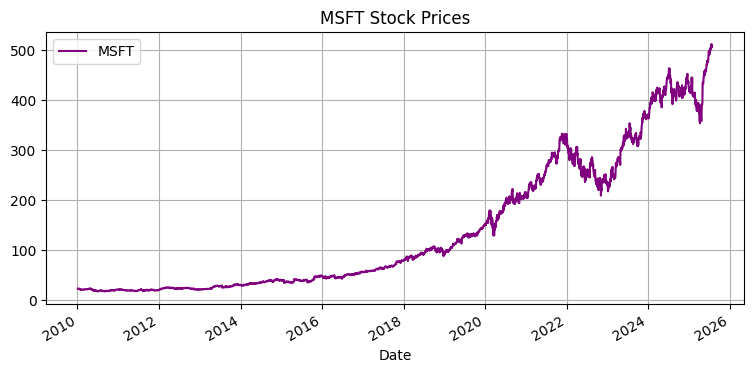

In [3]:
plt.subplots(figsize=(9, 4))
msft_df['Close'].plot(label='MSFT', color='purple')
plt.title('MSFT Stock Prices')
plt.grid()
plt.legend()

# 1. RF regression with lags as variables

In [41]:
split_date = pd.Timestamp("2024-08-02")

def create_features(df, window=5):
    X = pd.DataFrame(index=df.index)
    for i in range(1, window+1):
        X[f"close_lag_{i}"] = df["Close"].shift(i)
        X[f"vol_lag_{i}"] = df["Volume"].shift(i)
        X[f"high_lag_{i}"] = df["High"].shift(i)
        X[f"low_lag_{i}"] = df["Low"].shift(i)
    X.dropna(inplace=True)
    return X

# 1. Build features and align targets
features = create_features(msft_df)
targets  = msft_df["Close"].loc[features.index]

# 2. Split into train/test
train_X = features.loc[: split_date - pd.Timedelta(days=1)]
train_y = targets.loc[train_X.index]

test_X  = features.loc[split_date: ]
test_y  = targets.loc[test_X.index]

# 3. Fit and score
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_features='sqrt',
                           max_depth=20, min_samples_leaf=3, n_jobs=-1)
rf.fit(train_X, train_y)

preds = rf.predict(test_X)

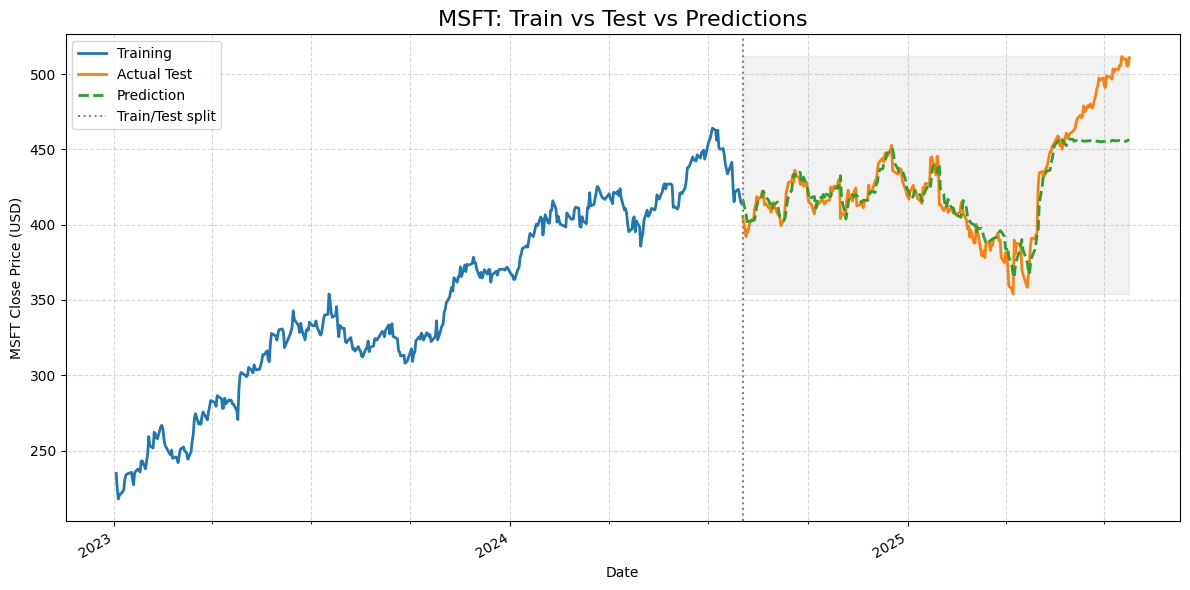

In [42]:
# Assume split_date is already a pd.Timestamp
fig, ax = plt.subplots(figsize=(12, 6))

# 1. Plot train, test, and predictions with thicker lines
ax.plot(train_y.loc['2023-01-01':].index, train_y.loc['2023-01-01':],     label="Training",    linewidth=2)
ax.plot(test_y.index,  test_y,      label="Actual Test",  linewidth=2)
ax.plot(test_y.index,  preds,       label="Prediction",   linewidth=2, linestyle="--")

# 2. Vertical line denoting the split
ax.axvline(split_date, color="gray", linestyle=":", label="Train/Test split")

# 3. Highlight test region
ax.fill_between(test_y.index, 
                test_y.min(), test_y.max(), 
                color="gray", alpha=0.1)

# 4. Axes labels & title
ax.set_xlabel("Date")
ax.set_ylabel("MSFT Close Price (USD)")
ax.set_title("MSFT: Train vs Test vs Predictions", fontsize=16)

# 5. Grid, legend, date formatting
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.legend(loc="upper left")

# Use nice tick spacing & rotation
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()


# Predictions

/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  war

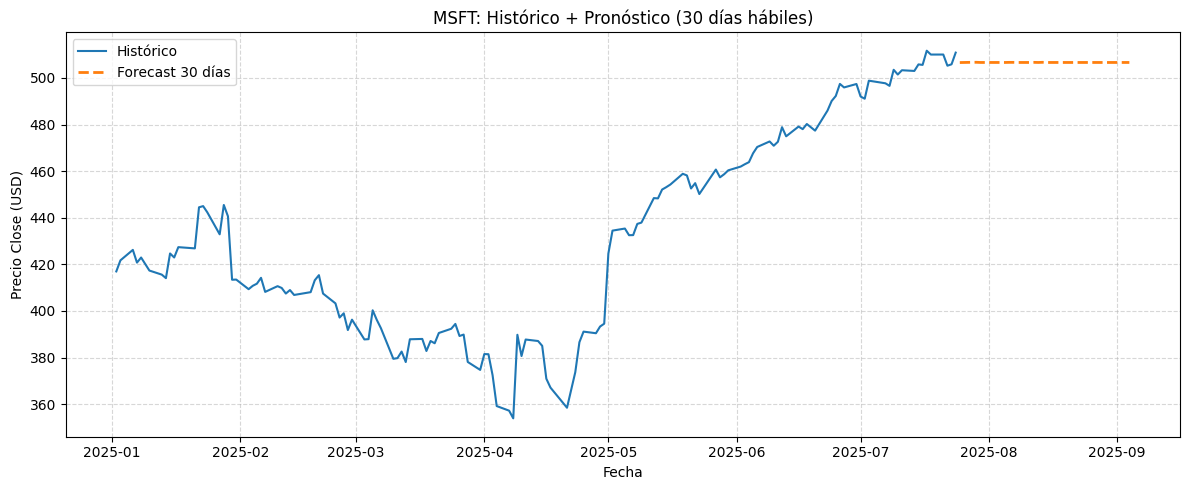

In [45]:
# 1. Build features and align targets
window = 20
features = create_features(msft_df, window)
targets  = msft_df["Close"].loc[features.index]

targets  = msft_df["Close"].loc[features.index]

# 3. Fit and score
rf = RandomForestRegressor(n_estimators=200, random_state=42, max_features=1/2,
                           max_depth=10, min_samples_leaf=5, n_jobs=-1)
rf.fit(features, targets)

# predicts 30 days after the late date in msft_df
last_date = msft_df.index.max()
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)

# 4. Semilla: la última fila de features
last_window = features.iloc[-1].copy()

# 5. Bucle recursivo de predicción
future_preds = []
for date in future_dates:
    # predict 1 paso
    pred = rf.predict(last_window.values.reshape(1, -1))[0]
    future_preds.append(pred)
    
    # actualiza la ventana: desplaza y coloca el nuevo pred en lag_1
    # (y para simplificar mantenemos Volume/High/Low = el mismo valor de Close)
    vals = last_window.copy()
    for i in range(window, 1, -1):
        vals[f"close_lag_{i}"] = vals[f"close_lag_{i-1}"]
        vals[f"high_lag_{i}"]  = vals[f"high_lag_{i-1}"]
        vals[f"low_lag_{i}"]   = vals[f"low_lag_{i-1}"]
        vals[f"vol_lag_{i}"]   = vals[f"vol_lag_{i-1}"]
    # ponemos en lag 1 la nueva predicción
    vals["close_lag_1"] = pred
    vals["high_lag_1"]  = pred
    vals["low_lag_1"]   = pred
    vals["vol_lag_1"]   = msft_df["Volume"].iloc[-1]  # o un valor promedio
    
    last_window = vals
# 6. Monta serie y dibuja
future_series = pd.Series(future_preds, index=future_dates, name="Forecast")

plt.figure(figsize=(12,5))
plt.plot(msft_df["Close"].loc['2025-01-01':], label="Histórico")
plt.plot(future_series,  label="Forecast 30 días", linestyle="--", linewidth=2)
plt.title("MSFT: Histórico + Pronóstico (30 días hábiles)")
plt.xlabel("Fecha"); plt.ylabel("Precio Close (USD)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Nota:

Dado que las hojas se construyen mediante desigualdades, RF no sabe decidir sobre máximos históricos, puesto que asigna valores aprendidos. Es decir, no extrapola aprendizaje.